# Monte Carlo simulation trial

In [143]:
%matplotlib inline
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy,imp 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii,fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from linetools.spectralline import AbsLine
import linetools.utils as ltu
from xastropy.igm.abs_sys import abssys_utils as abssys
from xastropy import spec as xpsec
from xastropy.plotting import utils as xputils
from xastropy.xutils import xdebug as xdb
from xastropy.obs import radec as xor
from xastropy.atomic import ionization as xai
from xastropy.xutils import fits as xxf
sys.path.append(os.path.abspath("../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("./Stacks/py"))
import qpq9_stacks as qpq9k
import scipy.integrate as integrate
from astropy.modeling import models,fitting
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70,Om0=0.26)

In [213]:
def gen_stck_img(R_phys,z_fg,Deltav,v_grid,n_trials): # R_phys in kpc, Deltav in km/s
    probs = np.zeros(len(v_grid))
    cumulative_probs = np.zeros(len(v_grid))
    Hubble_h = cosmo.H(0).value/100.
    ell_IGM_DLA = 0.2*((1+z_fg)/(1+2.5))**2.1
    ell_IGM_SLLS = 0.44*((1+z_fg)/(1+2.5))**2.1
    ell_IGM_LLS = 1.05*((1+z_fg)/(1+2.5))**2.1
    R_comov = R_phys/1000.*(1+z_fg)*Hubble_h # in h^-1 Mpc 
    for ii,vv in enumerate(v_grid):
        gamma_DLA = 1.6
        r0_DLA = 3.9
#        gamma_SLLS = 1.6
#        r0_SLLS = 15.5
#        gamma_LLS = 1.6
#        r0_LLS = 13.9
        gamma_SLLS = 1.68
        r0_SLLS = 14.0
        gamma_LLS = 1.68
        r0_LLS = 12.5
        chi_DLA = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg)))**2)/r0_DLA)**(-gamma_DLA),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        chi_SLLS = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg)))**2)/r0_SLLS)**(-gamma_SLLS),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        chi_LLS = 1./Deltav*integrate.quad(
            lambda v:(np.sqrt(R_comov**2+(v/(cosmo.H(z_fg).value/(1+z_fg)))**2)/r0_LLS)**(-gamma_LLS),
            v_grid[ii]-Deltav/2,v_grid[ii]+Deltav/2)[0]
        Deltaz = ltu.z_from_v(z_fg,v_grid[ii]+Deltav/2)-ltu.z_from_v(z_fg,v_grid[ii]-Deltav/2)
        prob = (ell_IGM_DLA*(1+chi_DLA)+ell_IGM_SLLS*(1+chi_SLLS)+ell_IGM_LLS*(1+chi_LLS))*Deltaz
        probs[ii] = prob
        cumulative_probs[ii] = prob + np.sum(probs[0:ii])
    norm = np.sum(probs)
    probs = probs/norm
    print('Expected number of absorbers at R_phys',norm,R_phys)
    
    stck_img = np.zeros((n_trials,len(v_grid)))
    for nt in np.arange(n_trials):
        N_abs = np.random.poisson(norm)
        flux = np.ones(len(v_grid))
        for ii,na in enumerate(np.arange(N_abs)):
            v_Hubble = np.random.choice(v_grid,p=probs)
            v_peculiar = np.random.normal(loc=0.,scale=212.) # sigma_1D for QPQ halo mass 
            # Want mean = 207 km/s, final dispersion = 352 km/s
            v_peculiar = np.random.normal(loc=140.,scale=315.)
            v_add = v_Hubble + v_peculiar
            # Try no peculiar velocity to find dispersion due to Hubble
            v_add = v_Hubble
        # rest EW = 0.3 angstrom, mean of QPQ8
#            one_abs = models.GaussianAbsorption1D(amplitude=0.74,mean=v_add,stddev=35.)
            # Higher rest EW to match data amplitude 
            one_abs = models.GaussianAbsorption1D(amplitude=3.0,mean=v_add,stddev=30.) 
            # To match amplitude for matching intrinsic dispersion = 352 km/s 
#            one_abs = models.GaussianAbsorption1D(amplitude=3.0,mean=v_add,stddev=30.)
            flux = flux*one_abs(v_grid)
            flux[np.where(flux < 0.)] = 0.
        stck_img[nt,:] = flux    
    
    return stck_img

rest EW in angstrom 0.669078641044


/Users/lwymarie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


[-200, 200, 0, 1.05]

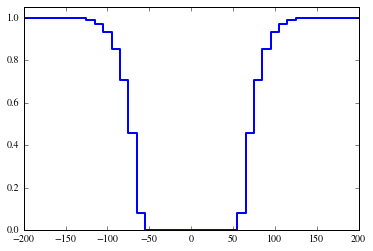

In [204]:
# Try CII absorbers of other amplitude, std_dev that preserve rest EW = 0.31 angstrom 
Deltav = 10.
v_grid = -2000. + np.arange((2000.-(-2000.))/Deltav+1)*Deltav
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
wave_grid = (v_grid*u.km/u.s).to(u.AA,equivalencies=relativistic_equiv)
#tau = models.Voigt1D(x_0=0.,amplitude_L=244,fwhm_L=0.7,fwhm_G=35)
#tau2 = models.Voigt1D(x_0=100.,amplitude_L=244,fwhm_L=0.7,fwhm_G=35)
#flux = np.exp(-1.*tau(v_grid))*np.exp(-1.*tau2(v_grid))
one_abs = models.GaussianAbsorption1D(amplitude=4.0,mean=0,stddev=35.)
flux = one_abs(v_grid)
flux[np.where(flux < 0.)] = 0.
tau = -np.log(flux)
total_flux = np.exp(-tau)
plt.plot(v_grid,total_flux,drawstyle='steps-mid',linewidth=2)
print('rest EW in angstrom',np.sum((1.-total_flux[:-1])*np.diff(wave_grid.value)))
plt.axis([-200,200,0,1.05])
#one_abs = models.GaussianAbsorption1D(amplitude=0.7,mean=0,stddev=39.)
#flux = one_abs(v_grid)
#tau = -np.log(flux)
#total_flux = np.exp(-2*tau)
#plt.plot(v_grid,total_flux,drawstyle='steps-mid',linewidth=2)
#print('rest EW in angstrom',np.sum((1.-total_flux[:-1])*np.diff(wave_grid.value)))

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
4.5030178527 1 / Angstrom
No spectrum found for BOSSJ0008-0039 and wvobs=3920.97 Angstrom!
3.96814209033 1 / Angstrom
No spectrum found for BOSSJ0042+1350 and wvobs=3704.79 Angstrom!
81.1223225091 1 / Angstrom
44.1513656402 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ034139.19-000012.7_b1200_F.fits.gz for SDSSJ0341-0000
S/N 81.1223225091 1 / Angstrom


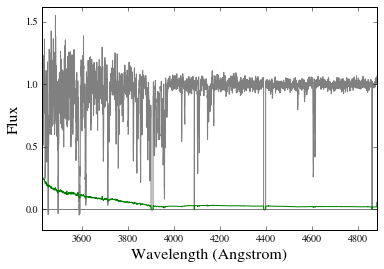

91.8691590217 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N 91.8691590217 1 / Angstrom


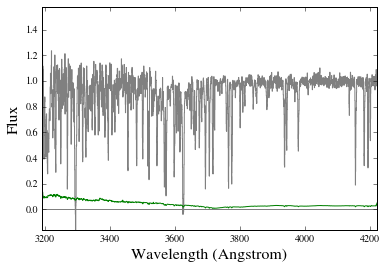

7.55904222746 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ080948.22+453929.0.fits for BOSSJ0809+4539
S/N 7.55904222746 1 / Angstrom


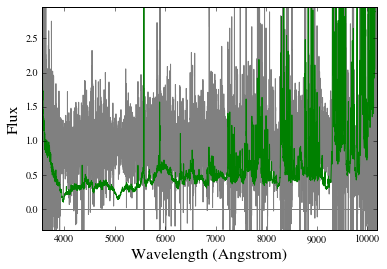

No spectrum found for BOSSJ0826+4708 and wvobs=3734.97 Angstrom!
7.18768185783 1 / Angstrom
30.4325951329 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ082844.87+454518.2_b1200_F.fits.gz for SDSSJ0828+4545
S/N 30.4325951329 1 / Angstrom


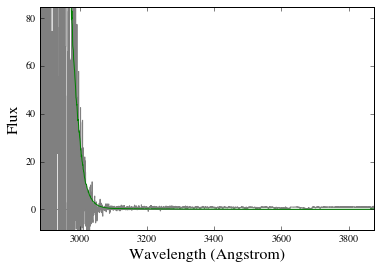

30.2325672808 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ083757.13+383722.4_b1200_F.fits.gz for APOJ0837+3837
S/N 30.2325672808 1 / Angstrom


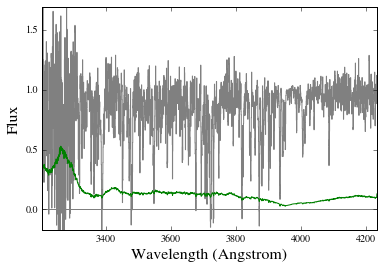

14.3637472477 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ084159.26+392140.0.fits for BOSSJ0841+3921
S/N 14.3637472477 1 / Angstrom


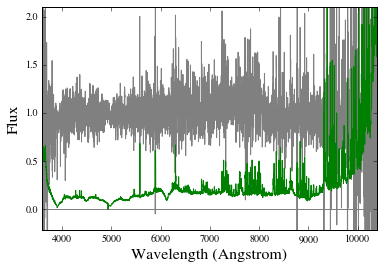

98.9433999318 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ085357.49-001106.1_F.fits.gz for BOSSJ0853-0011
S/N 98.9433999318 1 / Angstrom


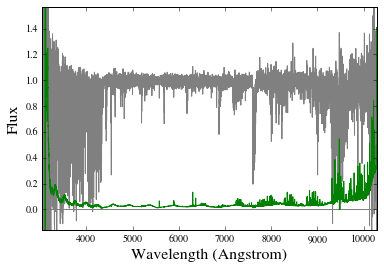

1.62381004726 1 / Angstrom
No spectrum found for BOSSJ0903+5133 and wvobs=3827.56 Angstrom!
No spectrum found for BOSSJ0904+0042 and wvobs=3493.83 Angstrom!
150.03949429 1 / Angstrom
17.3991571859 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/XSHOOTER_redux//./SDSSJ091338.97-010704.6_F.fits.gz for BOSSJ0913-0107
S/N 150.03949429 1 / Angstrom


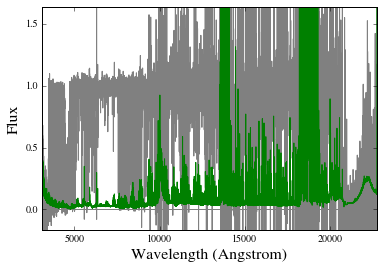

10.8041188824 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ091553.38+011911.3.fits for BOSSJ0915+0119
S/N 10.8041188824 1 / Angstrom


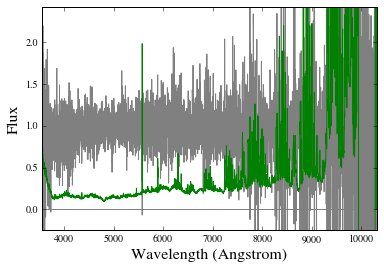

73.81824179 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ092416.73+392914.6_b1200_F.fits.gz for APOJ0924+3929
S/N 73.81824179 1 / Angstrom


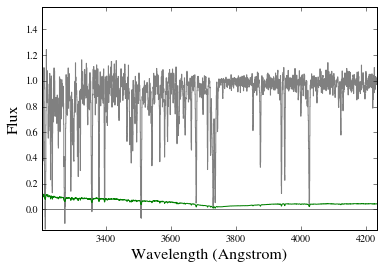

63.9766522587 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ093225.60+092500.2_F.fits.gz for APOJ0932+0925
S/N 63.9766522587 1 / Angstrom


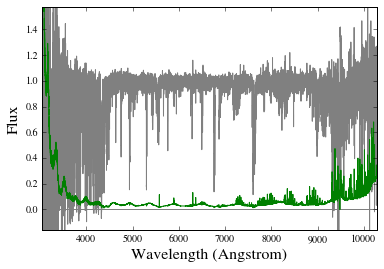

3.9769376434 1 / Angstrom
No spectrum found for BOSSJ1002+0020 and wvobs=4239.54 Angstrom!
61.5398404705 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ100507.08+501929.8_b1200_F.fits.gz for SDSSJ1005+5019
S/N 61.5398404705 1 / Angstrom


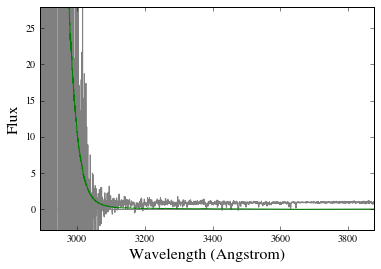

5.73742272355 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_6_0/SDSSJ100940.58+250053.9.fits for APOJ1009+2500
S/N 5.73742272355 1 / Angstrom


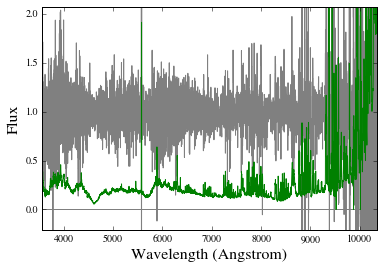

108.634313678 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ102616.12+461420.8_F.fits.gz for APOJ1026+4614
S/N 108.634313678 1 / Angstrom


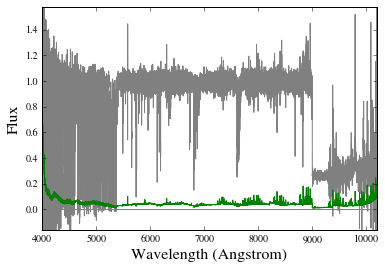

18.4091862035 1 / Angstrom
Using spec-6702-56381-0508.fits.gz for BOSSJ1036+5012
S/N 18.4091862035 1 / Angstrom


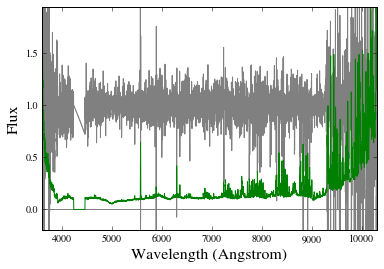

47.8324556688 1 / Angstrom
14.4231604961 1 / Angstrom
56.6214028343 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ103900.01+502652.8_F.fits.gz for BOSSJ1039+5026
S/N 56.6214028343 1 / Angstrom


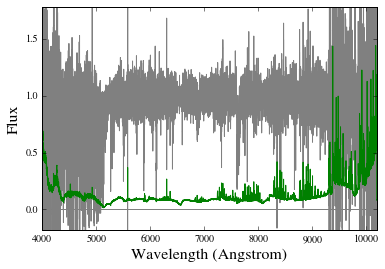

13.0086514544 1 / Angstrom
Using spec-7083-56722-0068.fits.gz for BOSSJ1042+6459
S/N 13.0086514544 1 / Angstrom


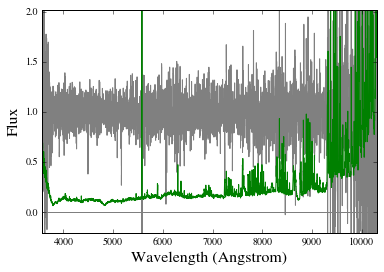

52.1925547055 1 / Angstrom
24.7137380174 1 / Angstrom
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ114145.43+072423.3_b400_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ114145.43+072423.3_b600_F.fits.gz for APOJ1141+0724
S/N 52.1925547055 1 / Angstrom


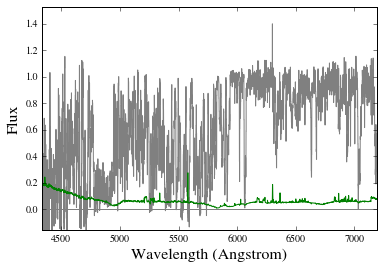

68.393253611 1 / Angstrom
143.628373235 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ114436.66+095904.9_F.fits.gz for BOSSJ1144+0959
S/N 143.628373235 1 / Angstrom


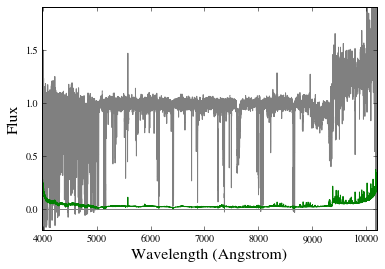

No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
142.871410019 1 / Angstrom
47.2201789204 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N 142.871410019 1 / Angstrom


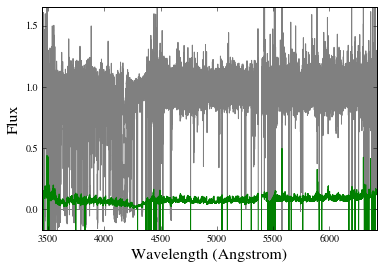

15.4016156076 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N 15.4016156076 1 / Angstrom


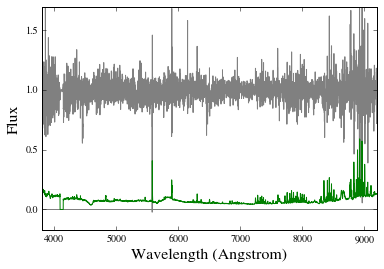

78.1873569683 1 / Angstrom
12.5385900365 1 / Angstrom
30.4123138554 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N 78.1873569683 1 / Angstrom


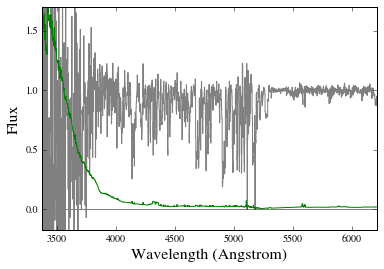

5.88738623429 1 / Angstrom
Using spec-6482-56358-0110.fits.gz for BOSSJ1244+3208
S/N 5.88738623429 1 / Angstrom


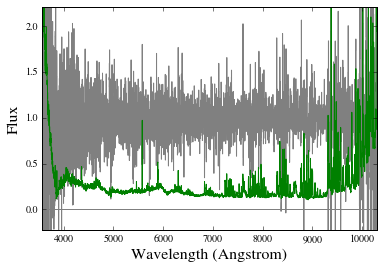

3.27963612433 1 / Angstrom
No spectrum found for BOSSJ1253+6327 and wvobs=3960.22 Angstrom!
32.2260362938 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ130603.55+615835.2_b1200_F.fits.gz for APOJ1306+6158
S/N 32.2260362938 1 / Angstrom


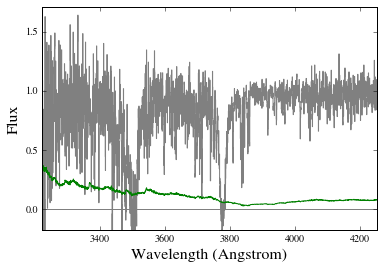

34.4735060467 1 / Angstrom
5.29411699216 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ135629.54+613310.4_b1200_F.fits.gz for BOSSJ1356+6133
S/N 34.4735060467 1 / Angstrom


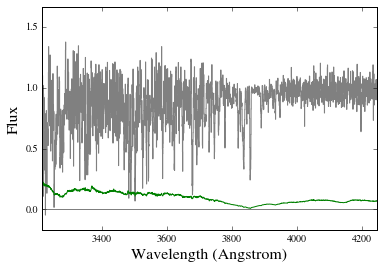

15.1103513223 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_6_0/SDSSJ135849.54+273756.9.fits for APOJ1358+2737
S/N 15.1103513223 1 / Angstrom


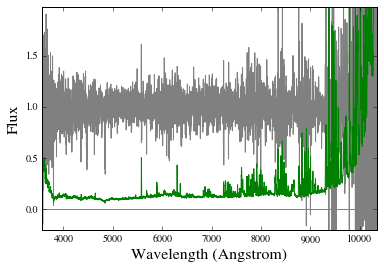

43.8456885446 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142054.92+160342.9_F.fits.gz for APOJ1420+1603
S/N 43.8456885446 1 / Angstrom


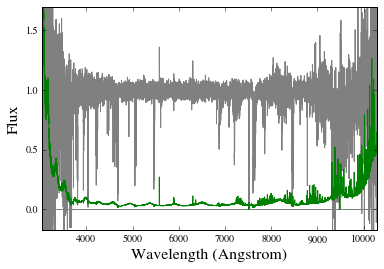

No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ142758.74-012136.2_b1200_F.fits.gz
138.502983858 1 / Angstrom
105.739031052 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_b_F.fits.gz for BOSSJ1427-0121
S/N 138.502983858 1 / Angstrom


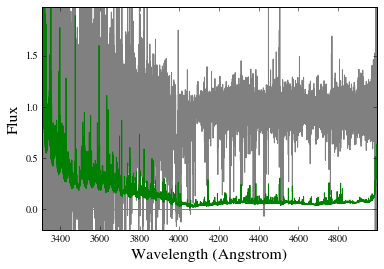

22.5711986597 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_4_45/SDSSJ143344.55+064111.9.fits for BOSSJ1433+0641
S/N 22.5711986597 1 / Angstrom


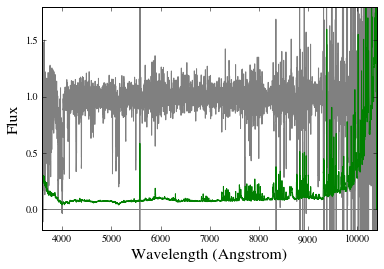

22.0937672202 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ155325.89+192137.7_F.fits.gz for APOJ1553+1921
S/N 22.0937672202 1 / Angstrom


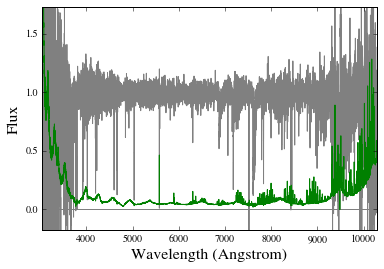

24.779005478 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ155946.28+494326.5_b1200_F.fits.gz for APOJ1559+4943
S/N 24.779005478 1 / Angstrom


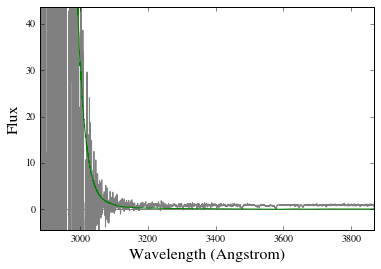

17.6300410978 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_6_0/SDSSJ160546.67+511323.0.fits for BOSSJ1605+5113
S/N 17.6300410978 1 / Angstrom


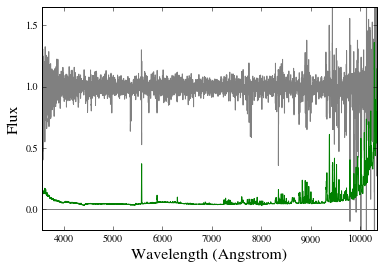

1.30299972739 1 / Angstrom
No spectrum found for BOSSJ1618+1842 and wvobs=4067.76 Angstrom!
121.295573564 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ162737.25+460609.3_F.fits.gz for APOJ1627+4606
S/N 121.295573564 1 / Angstrom


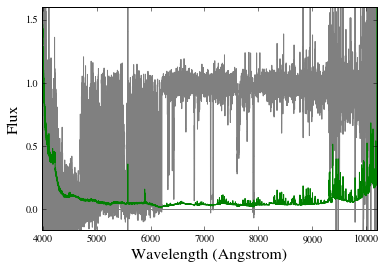

10.3337297074 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ225549.55-000927.7.fits for BOSSJ2255-0009
S/N 10.3337297074 1 / Angstrom


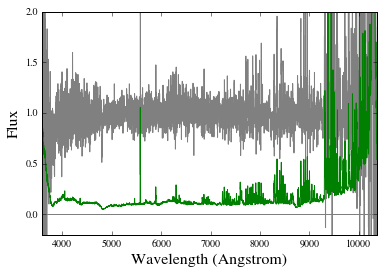

In [145]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,
                               zfg_mnx=(1.6,9999),atmosphere_cut=True)
fin_velo, stck_img, stck_msk, all_dict = stack_tup0

In [214]:
n_trials = 1000
Deltav = 10.
v_grid = -2000. + np.arange((2000.-(-2000.))/Deltav+1)*Deltav
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
wave_grid = (v_grid*u.km/u.s).to(u.AA,equivalencies=relativistic_equiv)
sv_mean_flux = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']:
        continue
    else:
        stck_img = gen_stck_img(idict['qpq']['R_PHYS'],idict['qpq']['Z_FG'],Deltav,v_grid,n_trials)
        mean_flux = np.sum(stck_img,0)/n_trials
        sv_mean_flux.append(mean_flux)

Expected number of absorbers at R_phys 0.494300301765 190.162078857
Expected number of absorbers at R_phys 0.420115278067 200.727334478
Expected number of absorbers at R_phys 0.351922729298 291.955898238
Expected number of absorbers at R_phys 0.480355291644 137.483764648
Expected number of absorbers at R_phys 0.7578484166 89.2255343659
Expected number of absorbers at R_phys 0.470555367371 182.693675263
Expected number of absorbers at R_phys 0.880441024878 111.641532541
Expected number of absorbers at R_phys 1.34179738531 88.838035754
Expected number of absorbers at R_phys 0.376001901972 235.999657906
Expected number of absorbers at R_phys 0.574246922955 106.124389648
Expected number of absorbers at R_phys 0.553284751914 237.906701175
Expected number of absorbers at R_phys 0.347259800466 211.233413696
Expected number of absorbers at R_phys 0.503320894793 127.239715576
Expected number of absorbers at R_phys 0.974525295216 288.342084422
Expected number of absorbers at R_phys 0.35538587952

Rest EW in angstrom: 0.329518137024
454.234066834
-1549308.63363


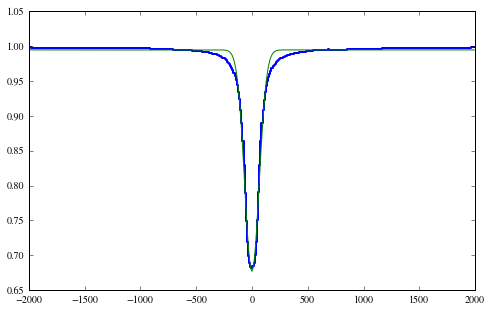

In [230]:
mean_flux = np.mean(sv_mean_flux,0)
plt.figure(figsize=(8,5))
plt.plot(v_grid,mean_flux,drawstyle='steps-mid',linewidth=2.,)
plt.axis([-2000,2000,0.65,1.05])
print('Rest EW in angstrom:',np.sum((1.-mean_flux[:-1])*np.diff(wave_grid.value)))
model_init = models.GaussianAbsorption1D(amplitude=0.11,mean=0.,stddev=250.)
c_init = models.Const1D(amplitude=0.997)
model_init = c_init*model_init
fit = fitting.LevMarLSQFitter()
model_final = fit(model_init,v_grid,mean_flux)
plt.plot(v_grid,model_final(v_grid))
model_final
tau = np.log(1./(mean_flux))
tau_disp = np.sqrt(np.sum(v_grid**2*tau)/np.sum(tau))
print(tau_disp)
print(np.sum((v_grid**2)*np.log(1/(mean_flux/0.994))))

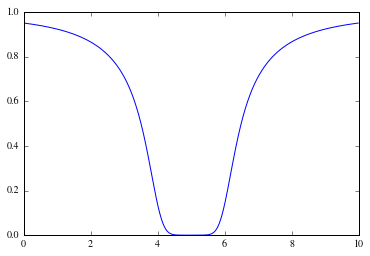

In [498]:
from astropy.modeling.models import Voigt1D
plt.figure()
x = np.arange(0, 10, 0.01)
v1 = Voigt1D(x_0=5, amplitude_L=20, fwhm_L=0.5, fwhm_G=0.9)
plt.plot(x, np.exp(-1.*v1(x)))
plt.show()

In [563]:
# Find mean equivalent width of QPQ8 LLS
np.mean([0.000,0.042,0.345,0.195,0.025,0.030,0.053,0.168,0.504,0.248,0.779,0.281,0.341,
         0.328,0.756,0.650,0.154,0.179,0.130,0.950])

0.30790000000000001

In [166]:
# Find mean redshift errors of QPQ9 CII systems
sigmas = np.array([272,44,272,272,300,44,44,272,272,272,44,272,272,395,272,44,272,395,44,44,44,44,272,300,272,272,44,
                   44,44,44,272,272,44,272])
np.mean(sigmas**2.)**(1/2.)

223.79730850507931